


# Building u-net for training

importing libary


In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt # metrics visuliztion
from PIL import Image # image visulizition
import cv2
from tqdm import tqdm

import torch # main framework
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid

from google.colab import drive #dataset from drive

# Mount Google Drive
drive.mount('/content/drive')

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Paths to Cityscapes dataset in Google Drive
DATASET_PATH = '/content/drive/MyDrive/cityscape'
IMG_PATH = os.path.join(DATASET_PATH, 'leftImg8bit') #image set
GT_PATH = os.path.join(DATASET_PATH, 'gtFine') # mask set

# Define lower resolution for images (to save memory)
IMG_HEIGHT = 256
IMG_WIDTH = 512

# Define the number of classes in Cityscapes (
NUM_CLASSES = 19


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


color maps

In [9]:
# Define color map for visualization
cityscapes_colors = [
    (0, 0, 0),         # 0: unlabeled
    (0, 0, 0),         # 1: ego vehicle
    (0, 0, 0),         # 2: rectification border
    (0, 0, 0),         # 3: out of roi
    (0, 0, 0),         # 4: static
    (0, 0, 0),         # 5: dynamic
    (0, 0, 0),         # 6: ground
    (0, 0, 70),        # 7: road - dark blue
    (255, 0, 255),     # 8: sidewalk - magenta
    (0, 0, 0),         # 9: parking
    (0, 0, 0),         # 10: rail track
    (255, 165, 0),     # 11: building - orange
    (190, 153, 153),   # 12: wall - light brown
    (170, 120, 220),   # 13: fence - light purple
    (0, 0, 0),         # 14: guard rail
    (0, 0, 0),         # 15: bridge
    (0, 0, 0),         # 16: tunnel
    (153, 153, 153),   # 17: pole - gray
    (0, 0, 0),         # 18: polegroup
    (250, 170, 30),    # 19: traffic light - amber
    (220, 220, 0),     # 20: traffic sign - yellow
    (35, 142, 35),     # 21: vegetation - forest green
    (152, 251, 152),   # 22: terrain - light green
    (70, 130, 180),    # 23: sky - steel blue
    (255, 0, 0),       # 24: person - bright red
    (255, 127, 0),     # 25: rider - dark orange
    (0, 0, 255),       # 26: car - bright blue
    (0, 150, 255),     # 27: truck - light blue
    (0, 80, 150),      # 28: bus - blue-gray
    (0, 0, 110),       # 29: caravan
    (0, 0, 110),       # 30: trailer
    (0, 80, 100),      # 31: train - dark blue-gray
    (0, 80, 100),      # 32: motorcycle - teal
    (119, 11, 32),     # 33: bicycle - maroon
]
# Mapping from Cityscapes IDs to training IDs (ignore label is 255)
id_to_trainid = {
    0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255,
    7: 0,    # road
    8: 1,    # sidewalk
    9: 255,  # parking
    10: 255, # rail track
    11: 2,   # building
    12: 3,   # wall
    13: 4,   # fence
    14: 255, # guard rail
    15: 255, # bridge
    16: 255, # tunnel
    17: 5,   # pole
    18: 255, # polegroup
    19: 6,   # traffic light
    20: 7,   # traffic sign
    21: 8,   # vegetation
    22: 9,   # terrain
    23: 10,  # sky
    24: 11,  # person
    25: 12,  # rider
    26: 13,  # car
    27: 14,  # truck
    28: 15,  # bus
    29: 255, # caravan
    30: 255, # trailer
    31: 16,  # train
    32: 17,  # motorcycle
    33: 18,  # bicycle
}

# Define class names for the 19 classes used for training
class_names = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
    'traffic light', 'traffic sign', 'vegetation', 'terrain',
    'sky', 'person', 'rider', 'car', 'truck', 'bus',
    'train', 'motorcycle', 'bicycle'
]


dataset path


In [10]:
class CityscapesSubset(Dataset):
    def __init__(self, root, split='train', transforms=None, subset_fraction=0.2):

        self.root = root
        self.split = split
        self.transforms = transforms
        self.subset_fraction = subset_fraction

        # List cities based on the split
        self.cities = os.listdir(os.path.join(IMG_PATH, split))

        self.images = []
        self.masks = []
        for city in self.cities:
            img_dir = os.path.join(IMG_PATH, split, city)
            mask_dir = os.path.join(GT_PATH, split, city)
            for file_name in os.listdir(img_dir):
                if file_name.endswith('_leftImg8bit.png'):
                    image_id = file_name.replace('_leftImg8bit.png', '')
                    mask_name = f"{image_id}_gtFine_labelIds.png"
                    img_path = os.path.join(img_dir, file_name)
                    mask_path = os.path.join(mask_dir, mask_name)
                    if os.path.exists(mask_path):
                        self.images.append(img_path)
                        self.masks.append(mask_path)

        # Create a subset of the dataset if needed
        if subset_fraction < 1.0:
            num_samples = int(len(self.images) * subset_fraction)
            indices = []
            city_samples = {}
            for i, img_path in enumerate(self.images):
                city = img_path.split('/')[-2]
                city_samples.setdefault(city, []).append(i)
            for city, samples in city_samples.items():
                city_ratio = len(samples) / len(self.images)
                num_city_samples = max(1, int(num_samples * city_ratio))
                city_indices = random.sample(samples, min(num_city_samples, len(samples)))
                indices.extend(city_indices)
            if len(indices) > num_samples:
                indices = random.sample(indices, num_samples)
            elif len(indices) < num_samples:
                remaining = num_samples - len(indices)
                all_indices = set(range(len(self.images)))
                used_indices = set(indices)
                unused_indices = list(all_indices - used_indices)
                if unused_indices:
                    indices.extend(random.sample(unused_indices, min(remaining, len(unused_indices))))
            self.images = [self.images[i] for i in indices]
            self.masks = [self.masks[i] for i in indices]

        print(f"Created {split} set with {len(self.images)} images from {len(self.cities)} cities")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path)

        # Resize images
        image = image.resize((IMG_WIDTH, IMG_HEIGHT), Image.BILINEAR)
        mask = mask.resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST)

        mask_np = np.array(mask)
        mask_out = np.ones_like(mask_np) * 255
        for id, train_id in id_to_trainid.items():
            mask_out[mask_np == id] = train_id
        mask = Image.fromarray(mask_out.astype(np.uint8))

        # Apply transformations
        if self.transforms:
            if self.split == 'train':
                image, mask = self.transforms(image, mask)
            else:
                image = TF.to_tensor(image)
                mask = torch.from_numpy(np.array(mask)).long()
        else:
            image = TF.to_tensor(image)
            mask = torch.from_numpy(np.array(mask)).long()

        return image, mask

class CityscapesTransforms:
    def __init__(self, p_flip=0.5, p_rotate=0.3, p_color=0.5):
        self.p_flip = p_flip
        self.p_rotate = p_rotate
        self.p_color = p_color
        self.color_jitter = transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        )

    def __call__(self, image, mask):
        image = TF.to_tensor(image)
        if random.random() < self.p_flip:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        if random.random() < self.p_rotate:
            angle = random.uniform(-10, 10)
            image = TF.rotate(image, angle, interpolation=TF.InterpolationMode.BILINEAR)
            mask = TF.rotate(mask, angle, interpolation=TF.InterpolationMode.NEAREST)
        if random.random() < self.p_color:
            image = self.color_jitter(image)
        mask = torch.from_numpy(np.array(mask)).long()
        return image, mask


u-net architecture

In [11]:
# U-Net model components
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


metrics

In [12]:
# Calculate Intersection over Union (IoU)
def calculate_iou(pred, target, n_classes):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    mask = (target != 255)
    pred = pred[mask]
    target = target[mask]
    for cls in range(n_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

# Calculate accuracy metrics
def calculate_accuracy_metrics(pred, target, n_classes):
    mask = (target != 255)
    pred = pred[mask]
    target = target[mask]
    correct = (pred == target).sum().item()
    total = mask.sum().item()
    pixel_acc = correct / total if total > 0 else 0
    class_accuracies = []
    for cls in range(n_classes):
        target_cls = target == cls
        if target_cls.sum().item() > 0:
            pred_cls = pred == cls
            class_correct = (pred_cls & target_cls).sum().item()
            class_total = target_cls.sum().item()
            class_accuracies.append(class_correct / class_total)
        else:
            class_accuracies.append(float('nan'))
    valid_accs = [acc for acc in class_accuracies if not np.isnan(acc)]
    mean_acc = np.mean(valid_accs) if valid_accs else 0
    return pixel_acc, mean_acc, class_accuracies

# Visualize predictions
def visualize_prediction(image, pred, target, class_colors):
    image = image.cpu().permute(1, 2, 0).numpy()
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    pred_color = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
    target_color = np.zeros((target.shape[0], target.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(class_colors[:NUM_CLASSES]):
        pred_color[pred == i] = color
        target_color[target == i] = color
    target_color[target == 255] = (0, 0, 0)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title('Input Image')
    axs[0].axis('off')
    axs[1].imshow(pred_color)
    axs[1].set_title('Prediction')
    axs[1].axis('off')
    axs[2].imshow(target_color)
    axs[2].set_title('Ground Truth')
    axs[2].axis('off')
    plt.tight_layout()
    return fig

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, scheduler=None):
    best_miou = 0.0
    best_accuracy = 0.0
    train_losses = []
    val_losses = []
    miou_scores = []
    pixel_acc_scores = []
    class_acc_scores = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        for images, masks in tqdm(train_loader, desc='Training'):
            images = images.to(device)
            masks = masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss = 0.0
        iou_scores = []
        pixel_accuracies = []
        mean_accuracies = []
        class_accuracies = [[] for _ in range(NUM_CLASSES)]
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc='Validation'):
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                batch_ious = calculate_iou(preds, masks, NUM_CLASSES)
                batch_pixel_acc, batch_mean_acc, batch_class_accs = calculate_accuracy_metrics(preds, masks, NUM_CLASSES)
                valid_ious = [iou for iou in batch_ious if not np.isnan(iou)]
                if valid_ious:
                    iou_scores.append(np.mean(valid_ious))
                pixel_accuracies.append(batch_pixel_acc)
                mean_accuracies.append(batch_mean_acc)
                for cls in range(NUM_CLASSES):
                    if not np.isnan(batch_class_accs[cls]):
                        class_accuracies[cls].append(batch_class_accs[cls])
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        mean_iou = np.mean(iou_scores)
        miou_scores.append(mean_iou)
        mean_pixel_acc = np.mean(pixel_accuracies)
        mean_class_acc = np.mean(mean_accuracies)
        pixel_acc_scores.append(mean_pixel_acc)
        class_acc_scores.append(mean_class_acc)
        avg_class_accuracies = []
        for cls in range(NUM_CLASSES):
            if class_accuracies[cls]:
                avg_class_accuracies.append(np.mean(class_accuracies[cls]))
        print(f'Training Loss: {epoch_loss:.4f}')
        print(f'Validation Loss: {epoch_val_loss:.4f}')
        print(f'Mean IoU: {mean_iou:.4f}')
        print(f'Overall Pixel Accuracy: {mean_pixel_acc:.4f}')
        print(f'Mean Class Accuracy: {mean_class_acc:.4f}')
        print("\nPer-class accuracies for important classes:")
        important_classes = [0, 11, 13, 24, 26]  # Example: road, building, car, person, etc.
        for cls in important_classes:
            if cls < len(class_names) and avg_class_accuracies[cls]:
                print(f"{class_names[cls]}: {avg_class_accuracies[cls]:.4f}")
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(mean_iou)
            else:
                scheduler.step()
        if mean_iou > best_miou:
            best_miou = mean_iou
            torch.save(model.state_dict(), 'best_unet_model_iou.pth')
            print('Best IoU model saved!')
        if mean_pixel_acc > best_accuracy:
            best_accuracy = mean_pixel_acc
            torch.save(model.state_dict(), 'best_unet_model_accuracy.pth')
            print('Best Accuracy model saved!')
        print()
    print("Loading best accuracy model for evaluation...")
    model.load_state_dict(torch.load('best_unet_model_accuracy.pth'))
    return model, train_losses, val_losses, miou_scores, pixel_acc_scores, class_acc_scores


setups and data tranformation

Using device: cuda
Created train set with 595 images from 18 cities
Created val set with 150 images from 3 cities
Epoch 1/50
----------


Validation: 100%|██████████| 19/19 [01:05<00:00,  3.46s/it]


Training Loss: 1.9044
Validation Loss: 1.4395
Mean IoU: 0.1814
Overall Pixel Accuracy: 0.7618
Mean Class Accuracy: 0.2354

Per-class accuracies for important classes:
road: 0.9744
person: 0.0061
car: 0.7537
Best IoU model saved!
Best Accuracy model saved!

Epoch 2/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.23it/s]


Training Loss: 1.3911
Validation Loss: 1.2233
Mean IoU: 0.1980
Overall Pixel Accuracy: 0.7785
Mean Class Accuracy: 0.2720

Per-class accuracies for important classes:
road: 0.9177
person: 0.0630
car: 0.7974
Best IoU model saved!
Best Accuracy model saved!

Epoch 3/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.23it/s]


Training Loss: 1.1610
Validation Loss: 1.0849
Mean IoU: 0.2235
Overall Pixel Accuracy: 0.8073
Mean Class Accuracy: 0.2985

Per-class accuracies for important classes:
road: 0.9202
person: 0.3680
car: 0.7661
Best IoU model saved!
Best Accuracy model saved!

Epoch 4/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Training Loss: 1.0059
Validation Loss: 0.9032
Mean IoU: 0.2402
Overall Pixel Accuracy: 0.8292
Mean Class Accuracy: 0.3007

Per-class accuracies for important classes:
road: 0.9609
person: 0.2532
car: 0.7629
Best IoU model saved!
Best Accuracy model saved!

Epoch 5/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.23it/s]


Training Loss: 0.8924
Validation Loss: 0.8612
Mean IoU: 0.2457
Overall Pixel Accuracy: 0.8252
Mean Class Accuracy: 0.3223

Per-class accuracies for important classes:
road: 0.9797
person: 0.5818
car: 0.8166
Best IoU model saved!

Epoch 6/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


Training Loss: 0.8006
Validation Loss: 0.7779
Mean IoU: 0.2640
Overall Pixel Accuracy: 0.8371
Mean Class Accuracy: 0.3320

Per-class accuracies for important classes:
road: 0.9384
person: 0.3632
car: 0.7495
Best IoU model saved!
Best Accuracy model saved!

Epoch 7/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


Training Loss: 0.7423
Validation Loss: 0.7309
Mean IoU: 0.2708
Overall Pixel Accuracy: 0.8476
Mean Class Accuracy: 0.3506

Per-class accuracies for important classes:
road: 0.9588
person: 0.6449
car: 0.7949
Best IoU model saved!
Best Accuracy model saved!

Epoch 8/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


Training Loss: 0.6842
Validation Loss: 0.6634
Mean IoU: 0.2820
Overall Pixel Accuracy: 0.8571
Mean Class Accuracy: 0.3404

Per-class accuracies for important classes:
road: 0.9649
person: 0.3710
car: 0.8601
Best IoU model saved!
Best Accuracy model saved!

Epoch 9/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.23it/s]


Training Loss: 0.6547
Validation Loss: 0.6361
Mean IoU: 0.2780
Overall Pixel Accuracy: 0.8517
Mean Class Accuracy: 0.3479

Per-class accuracies for important classes:
road: 0.9776
person: 0.6808
car: 0.8063

Epoch 10/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


Training Loss: 0.6311
Validation Loss: 0.6675
Mean IoU: 0.2778
Overall Pixel Accuracy: 0.8419
Mean Class Accuracy: 0.3326

Per-class accuracies for important classes:
road: 0.9417
person: 0.2716
car: 0.8412

Epoch 11/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Training Loss: 0.5922
Validation Loss: 0.5779
Mean IoU: 0.2955
Overall Pixel Accuracy: 0.8633
Mean Class Accuracy: 0.3620

Per-class accuracies for important classes:
road: 0.9786
person: 0.6180
car: 0.9205
Best IoU model saved!
Best Accuracy model saved!

Epoch 12/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


Training Loss: 0.5653
Validation Loss: 0.5850
Mean IoU: 0.2946
Overall Pixel Accuracy: 0.8623
Mean Class Accuracy: 0.3547

Per-class accuracies for important classes:
road: 0.9813
person: 0.4357
car: 0.9399

Epoch 13/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Training Loss: 0.5404
Validation Loss: 0.5346
Mean IoU: 0.3111
Overall Pixel Accuracy: 0.8726
Mean Class Accuracy: 0.3770

Per-class accuracies for important classes:
road: 0.9777
person: 0.5553
car: 0.9194
Best IoU model saved!
Best Accuracy model saved!

Epoch 14/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.19it/s]


Training Loss: 0.5061
Validation Loss: 0.5317
Mean IoU: 0.3182
Overall Pixel Accuracy: 0.8704
Mean Class Accuracy: 0.3930

Per-class accuracies for important classes:
road: 0.9679
person: 0.5818
car: 0.9038
Best IoU model saved!

Epoch 15/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.19it/s]


Training Loss: 0.4998
Validation Loss: 0.6311
Mean IoU: 0.2822
Overall Pixel Accuracy: 0.8324
Mean Class Accuracy: 0.3556

Per-class accuracies for important classes:
road: 0.9115
person: 0.5555
car: 0.6296

Epoch 16/50
----------


Validation: 100%|██████████| 19/19 [00:16<00:00,  1.17it/s]


Training Loss: 0.5034
Validation Loss: 0.5119
Mean IoU: 0.3228
Overall Pixel Accuracy: 0.8737
Mean Class Accuracy: 0.4013

Per-class accuracies for important classes:
road: 0.9747
person: 0.5524
car: 0.8287
Best IoU model saved!
Best Accuracy model saved!

Epoch 17/50
----------


Validation: 100%|██████████| 19/19 [00:16<00:00,  1.18it/s]


Training Loss: 0.4783
Validation Loss: 0.5051
Mean IoU: 0.3161
Overall Pixel Accuracy: 0.8715
Mean Class Accuracy: 0.3992

Per-class accuracies for important classes:
road: 0.9770
person: 0.7127
car: 0.9074

Epoch 18/50
----------


Validation: 100%|██████████| 19/19 [00:16<00:00,  1.18it/s]


Training Loss: 0.4488
Validation Loss: 0.5040
Mean IoU: 0.3239
Overall Pixel Accuracy: 0.8731
Mean Class Accuracy: 0.3862

Per-class accuracies for important classes:
road: 0.9786
person: 0.5618
car: 0.8452
Best IoU model saved!

Epoch 19/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Training Loss: 0.4607
Validation Loss: 0.4762
Mean IoU: 0.3308
Overall Pixel Accuracy: 0.8799
Mean Class Accuracy: 0.4057

Per-class accuracies for important classes:
road: 0.9751
person: 0.4530
car: 0.9414
Best IoU model saved!
Best Accuracy model saved!

Epoch 20/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.26it/s]


Training Loss: 0.4348
Validation Loss: 0.5070
Mean IoU: 0.3215
Overall Pixel Accuracy: 0.8725
Mean Class Accuracy: 0.3782

Per-class accuracies for important classes:
road: 0.9826
person: 0.3685
car: 0.8876

Epoch 21/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Training Loss: 0.4192
Validation Loss: 0.4518
Mean IoU: 0.3471
Overall Pixel Accuracy: 0.8861
Mean Class Accuracy: 0.4144

Per-class accuracies for important classes:
road: 0.9776
person: 0.5948
car: 0.9063
Best IoU model saved!
Best Accuracy model saved!

Epoch 22/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


Training Loss: 0.4043
Validation Loss: 0.4533
Mean IoU: 0.3474
Overall Pixel Accuracy: 0.8820
Mean Class Accuracy: 0.4244

Per-class accuracies for important classes:
road: 0.9750
person: 0.5550
car: 0.8666
Best IoU model saved!

Epoch 23/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Training Loss: 0.3887
Validation Loss: 0.4409
Mean IoU: 0.3489
Overall Pixel Accuracy: 0.8891
Mean Class Accuracy: 0.4224

Per-class accuracies for important classes:
road: 0.9764
person: 0.5293
car: 0.9370
Best IoU model saved!
Best Accuracy model saved!

Epoch 24/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Training Loss: 0.4113
Validation Loss: 0.5100
Mean IoU: 0.3273
Overall Pixel Accuracy: 0.8646
Mean Class Accuracy: 0.3959

Per-class accuracies for important classes:
road: 0.9786
person: 0.4394
car: 0.9409

Epoch 25/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.19it/s]


Training Loss: 0.3866
Validation Loss: 0.4250
Mean IoU: 0.3673
Overall Pixel Accuracy: 0.8874
Mean Class Accuracy: 0.4468

Per-class accuracies for important classes:
road: 0.9735
person: 0.5547
car: 0.8882
Best IoU model saved!

Epoch 26/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.26it/s]


Training Loss: 0.3618
Validation Loss: 0.4354
Mean IoU: 0.3599
Overall Pixel Accuracy: 0.8861
Mean Class Accuracy: 0.4400

Per-class accuracies for important classes:
road: 0.9710
person: 0.5424
car: 0.8816

Epoch 27/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Training Loss: 0.3447
Validation Loss: 0.4304
Mean IoU: 0.3512
Overall Pixel Accuracy: 0.8867
Mean Class Accuracy: 0.4522

Per-class accuracies for important classes:
road: 0.9778
person: 0.3260
car: 0.9233

Epoch 28/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Training Loss: 0.3468
Validation Loss: 0.4381
Mean IoU: 0.3505
Overall Pixel Accuracy: 0.8832
Mean Class Accuracy: 0.4560

Per-class accuracies for important classes:
road: 0.9771
person: 0.6965
car: 0.9401

Epoch 29/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Training Loss: 0.3504
Validation Loss: 0.4087
Mean IoU: 0.3686
Overall Pixel Accuracy: 0.8885
Mean Class Accuracy: 0.4701

Per-class accuracies for important classes:
road: 0.9764
person: 0.6852
car: 0.9371
Best IoU model saved!

Epoch 30/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


Training Loss: 0.3330
Validation Loss: 0.4141
Mean IoU: 0.3640
Overall Pixel Accuracy: 0.8878
Mean Class Accuracy: 0.4731

Per-class accuracies for important classes:
road: 0.9690
person: 0.3093
car: 0.9303

Epoch 31/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.26it/s]


Training Loss: 0.3232
Validation Loss: 0.4007
Mean IoU: 0.3732
Overall Pixel Accuracy: 0.8917
Mean Class Accuracy: 0.4711

Per-class accuracies for important classes:
road: 0.9767
person: 0.5421
car: 0.9289
Best IoU model saved!
Best Accuracy model saved!

Epoch 32/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


Training Loss: 0.3160
Validation Loss: 0.4154
Mean IoU: 0.3654
Overall Pixel Accuracy: 0.8868
Mean Class Accuracy: 0.4796

Per-class accuracies for important classes:
road: 0.9785
person: 0.6926
car: 0.8911

Epoch 33/50
----------


Validation: 100%|██████████| 19/19 [00:16<00:00,  1.17it/s]


Training Loss: 0.3130
Validation Loss: 0.3991
Mean IoU: 0.3777
Overall Pixel Accuracy: 0.8932
Mean Class Accuracy: 0.4650

Per-class accuracies for important classes:
road: 0.9773
person: 0.4765
car: 0.9162
Best IoU model saved!
Best Accuracy model saved!

Epoch 34/50
----------


Validation: 100%|██████████| 19/19 [00:16<00:00,  1.19it/s]


Training Loss: 0.3019
Validation Loss: 0.3923
Mean IoU: 0.3787
Overall Pixel Accuracy: 0.8929
Mean Class Accuracy: 0.4742

Per-class accuracies for important classes:
road: 0.9870
person: 0.6539
car: 0.9273
Best IoU model saved!

Epoch 35/50
----------


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.27it/s]


Training Loss: 0.2835
Validation Loss: 0.3847
Mean IoU: 0.3862
Overall Pixel Accuracy: 0.8952
Mean Class Accuracy: 0.4926

Per-class accuracies for important classes:
road: 0.9832
person: 0.6115
car: 0.9279
Best IoU model saved!
Best Accuracy model saved!

Epoch 36/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.26it/s]


Training Loss: 0.2767
Validation Loss: 0.3962
Mean IoU: 0.3857
Overall Pixel Accuracy: 0.8918
Mean Class Accuracy: 0.4907

Per-class accuracies for important classes:
road: 0.9725
person: 0.6506
car: 0.9164

Epoch 37/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


Training Loss: 0.2758
Validation Loss: 0.3909
Mean IoU: 0.3818
Overall Pixel Accuracy: 0.8932
Mean Class Accuracy: 0.4850

Per-class accuracies for important classes:
road: 0.9783
person: 0.7294
car: 0.8936

Epoch 38/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Training Loss: 0.2723
Validation Loss: 0.3862
Mean IoU: 0.3912
Overall Pixel Accuracy: 0.8940
Mean Class Accuracy: 0.4988

Per-class accuracies for important classes:
road: 0.9651
person: 0.5802
car: 0.9025
Best IoU model saved!

Epoch 39/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Training Loss: 0.2625
Validation Loss: 0.3861
Mean IoU: 0.3860
Overall Pixel Accuracy: 0.8957
Mean Class Accuracy: 0.4835

Per-class accuracies for important classes:
road: 0.9796
person: 0.7069
car: 0.8583
Best Accuracy model saved!

Epoch 40/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.26it/s]


Training Loss: 0.2778
Validation Loss: 0.4137
Mean IoU: 0.3725
Overall Pixel Accuracy: 0.8835
Mean Class Accuracy: 0.4930

Per-class accuracies for important classes:
road: 0.9695
person: 0.6872
car: 0.8445

Epoch 41/50
----------


Validation: 100%|██████████| 19/19 [00:16<00:00,  1.18it/s]


Training Loss: 0.2636
Validation Loss: 0.3626
Mean IoU: 0.3995
Overall Pixel Accuracy: 0.9015
Mean Class Accuracy: 0.5025

Per-class accuracies for important classes:
road: 0.9820
person: 0.6215
car: 0.9376
Best IoU model saved!
Best Accuracy model saved!

Epoch 42/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.23it/s]


Training Loss: 0.2483
Validation Loss: 0.3699
Mean IoU: 0.3977
Overall Pixel Accuracy: 0.8994
Mean Class Accuracy: 0.5000

Per-class accuracies for important classes:
road: 0.9768
person: 0.6012
car: 0.9340

Epoch 43/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


Training Loss: 0.2581
Validation Loss: 0.3666
Mean IoU: 0.3979
Overall Pixel Accuracy: 0.8964
Mean Class Accuracy: 0.5123

Per-class accuracies for important classes:
road: 0.9707
person: 0.5863
car: 0.9231

Epoch 44/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Training Loss: 0.2452
Validation Loss: 0.3902
Mean IoU: 0.3902
Overall Pixel Accuracy: 0.8933
Mean Class Accuracy: 0.5028

Per-class accuracies for important classes:
road: 0.9777
person: 0.6206
car: 0.9056

Epoch 45/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.27it/s]


Training Loss: 0.2423
Validation Loss: 0.3563
Mean IoU: 0.4005
Overall Pixel Accuracy: 0.9004
Mean Class Accuracy: 0.5219

Per-class accuracies for important classes:
road: 0.9781
person: 0.6413
car: 0.9408
Best IoU model saved!

Epoch 46/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.26it/s]


Training Loss: 0.2245
Validation Loss: 0.3603
Mean IoU: 0.3984
Overall Pixel Accuracy: 0.9017
Mean Class Accuracy: 0.5085

Per-class accuracies for important classes:
road: 0.9846
person: 0.6813
car: 0.9256
Best Accuracy model saved!

Epoch 47/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Training Loss: 0.2279
Validation Loss: 0.3572
Mean IoU: 0.4083
Overall Pixel Accuracy: 0.9001
Mean Class Accuracy: 0.5274

Per-class accuracies for important classes:
road: 0.9802
person: 0.6772
car: 0.9438
Best IoU model saved!

Epoch 48/50
----------


Validation: 100%|██████████| 19/19 [00:16<00:00,  1.16it/s]


Training Loss: 0.2155
Validation Loss: 0.3682
Mean IoU: 0.4067
Overall Pixel Accuracy: 0.8994
Mean Class Accuracy: 0.5199

Per-class accuracies for important classes:
road: 0.9836
person: 0.6190
car: 0.9093

Epoch 49/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Training Loss: 0.2149
Validation Loss: 0.3851
Mean IoU: 0.4055
Overall Pixel Accuracy: 0.8984
Mean Class Accuracy: 0.5203

Per-class accuracies for important classes:
road: 0.9801
person: 0.5388
car: 0.9440

Epoch 50/50
----------


Validation: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Training Loss: 0.2289
Validation Loss: 0.4012
Mean IoU: 0.3854
Overall Pixel Accuracy: 0.8950
Mean Class Accuracy: 0.4973

Per-class accuracies for important classes:
road: 0.9832
person: 0.5300
car: 0.9431

Loading best accuracy model for evaluation...


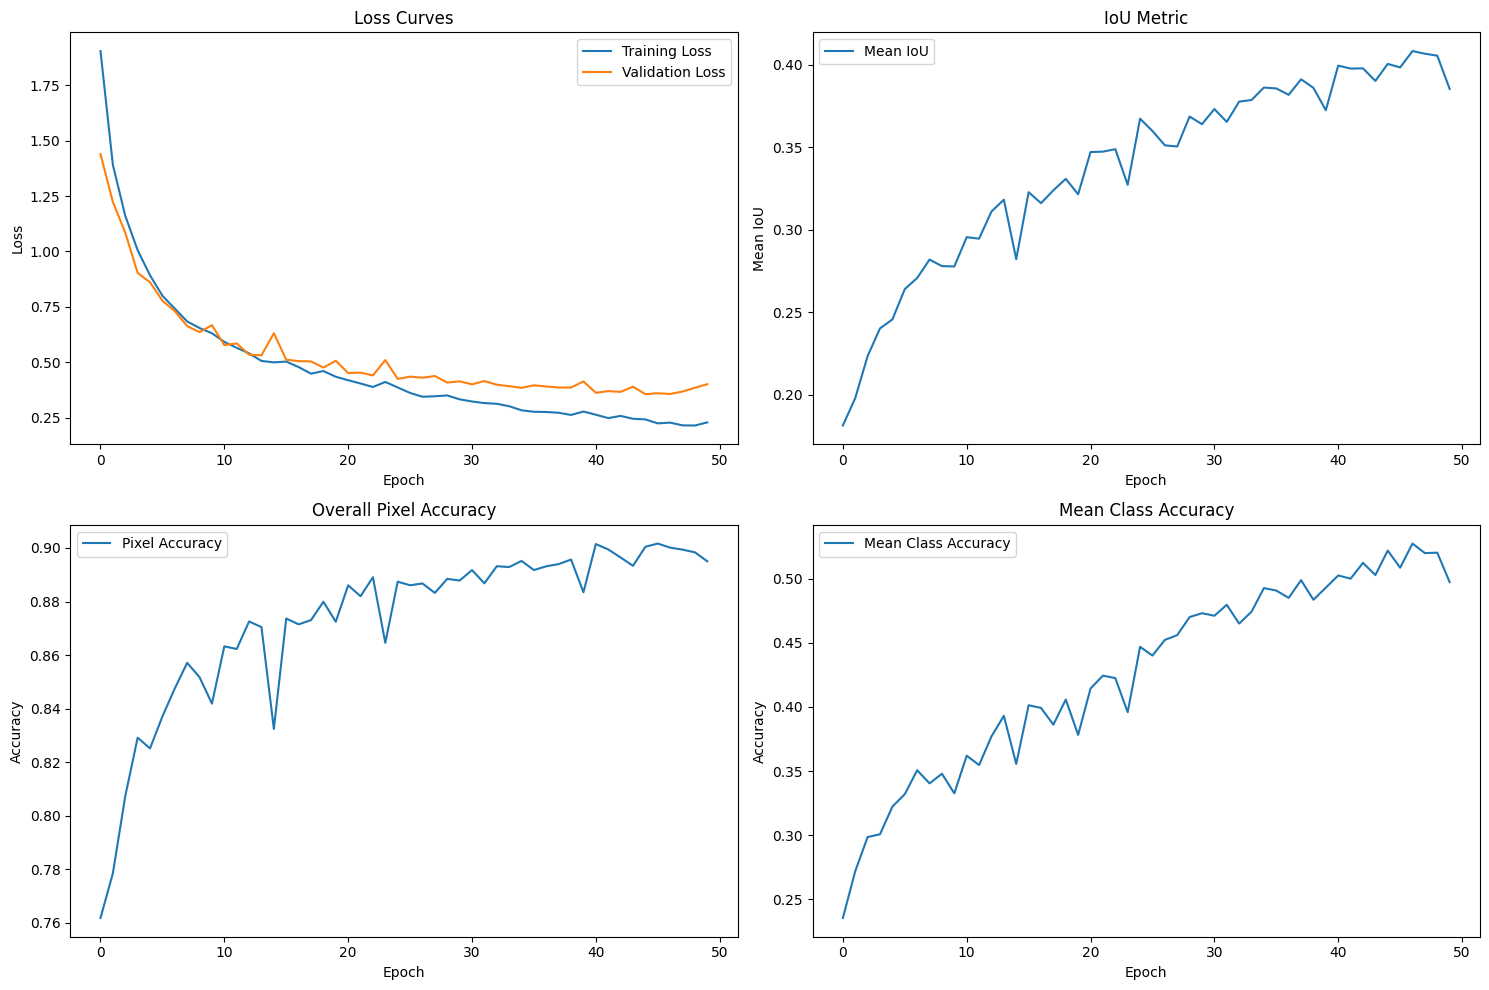


Evaluating final model on validation set...


Final Evaluation: 100%|██████████| 19/19 [00:15<00:00,  1.22it/s]



Final Evaluation Results:
Mean IoU: 0.3984
Overall Pixel Accuracy: 0.9017
Mean Class Accuracy: 0.5085

Creating prediction video for munster...
Prediction video saved to prediction_video.mp4


In [13]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Create datasets with transformations
    train_transforms = CityscapesTransforms(p_flip=0.5, p_rotate=0.3, p_color=0.8)
    train_dataset = CityscapesSubset(
        root=DATASET_PATH,
        split='train',
        transforms=train_transforms,
        subset_fraction=0.2  # Use 20% of training data
    )
    val_dataset = CityscapesSubset(
        root=DATASET_PATH,
        split='val',
        transforms=None,  # No augmentation for validation
        subset_fraction=0.3  # Use 30% of validation data
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Create model
    model = UNet(n_channels=3, n_classes=NUM_CLASSES, bilinear=True)
    model = model.to(device)

    # Define loss and optimizer (with class weights)
    class_weights = torch.ones(NUM_CLASSES).to(device)
    class_weights[6] = 2.0   # traffic light
    class_weights[11] = 2.0  # person
    class_weights[12] = 2.0  # rider
    class_weights[17] = 2.0  # motorcycle
    class_weights[18] = 2.0  # bicycle
    criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=3,
        verbose=True
    )

    # Train the model
    model, train_losses, val_losses, miou_scores, pixel_acc_scores, class_acc_scores = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=50,  # Adjust number of epochs as needed
        scheduler=scheduler
    )

    # Plot training progress
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(2, 2, 2)
    plt.plot(miou_scores, label='Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('Mean IoU')
    plt.legend()
    plt.title('IoU Metric')

    plt.subplot(2, 2, 3)
    plt.plot(pixel_acc_scores, label='Pixel Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Overall Pixel Accuracy')

    plt.subplot(2, 2, 4)
    plt.plot(class_acc_scores, label='Mean Class Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Mean Class Accuracy')

    plt.tight_layout()
    plt.savefig('training_progress.png')
    plt.show()

    # Save training metrics
    import pandas as pd
    metrics_df = pd.DataFrame({
        'Epoch': range(1, len(train_losses) + 1),
        'Training_Loss': train_losses,
        'Validation_Loss': val_losses,
        'Mean_IoU': miou_scores,
        'Pixel_Accuracy': pixel_acc_scores,
        'Class_Accuracy': class_acc_scores
    })
    metrics_df.to_csv('training_metrics.csv', index=False)

    # Final evaluation on validation set
    model.eval()
    all_pixel_accs = []
    all_class_accs = []
    all_ious = []
    print("\nEvaluating final model on validation set...")
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc='Final Evaluation'):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            batch_ious = calculate_iou(preds, masks, NUM_CLASSES)
            batch_pixel_acc, batch_mean_acc, _ = calculate_accuracy_metrics(preds, masks, NUM_CLASSES)
            valid_ious = [iou for iou in batch_ious if not np.isnan(iou)]
            if valid_ious:
                all_ious.append(np.mean(valid_ious))
            all_pixel_accs.append(batch_pixel_acc)
            all_class_accs.append(batch_mean_acc)
    final_miou = np.mean(all_ious)
    final_pixel_acc = np.mean(all_pixel_accs)
    final_class_acc = np.mean(all_class_accs)
    print(f"\nFinal Evaluation Results:")
    print(f"Mean IoU: {final_miou:.4f}")
    print(f"Overall Pixel Accuracy: {final_pixel_acc:.4f}")
    print(f"Mean Class Accuracy: {final_class_acc:.4f}")

    # Visualize some validation predictions
    test_samples = min(5, len(val_dataset))
    for i in range(test_samples):
        image, mask = val_dataset[i]
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            pred = torch.argmax(output, dim=1).squeeze(0).cpu()
        fig = visualize_prediction(image.squeeze(0), pred, mask, cityscapes_colors)
        plt.savefig(f'prediction_{i}.png')
        plt.close(fig)

    # Create prediction video for a sequence (if available)
    try:
        sequential_city = val_dataset.cities[0]
        city_img_dir = os.path.join(IMG_PATH, 'val', sequential_city)
        city_images = sorted([f for f in os.listdir(city_img_dir) if f.endswith('_leftImg8bit.png')])
        if len(city_images) > 10:
            print(f"\nCreating prediction video for {sequential_city}...")
            frames = []
            for idx, img_file in enumerate(city_images[:20]):
                img_path = os.path.join(city_img_dir, img_file)
                image = Image.open(img_path).convert('RGB')
                image = image.resize((IMG_WIDTH, IMG_HEIGHT), Image.BILINEAR)
                image_tensor = TF.to_tensor(image).unsqueeze(0).to(device)
                with torch.no_grad():
                    output = model(image_tensor)
                    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
                pred_color = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
                for i, color in enumerate(cityscapes_colors[:NUM_CLASSES]):
                    pred_color[pred == i] = color
                image_np = np.array(image)
                combined = np.hstack([image_np, pred_color])
                frames.append(combined)
            if frames:
                out_path = 'prediction_video.mp4'
                height, width, _ = frames[0].shape
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                video = cv2.VideoWriter(out_path, fourcc, 5, (width, height))
                for frame in frames:
                    video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
                video.release()
                print(f"Prediction video saved to {out_path}")
    except Exception as e:
        print(f"Could not create video: {e}")

if __name__ == '__main__':
    main()


# inference

imports

In [30]:
# U-Net Segmentation inference
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF
from google.colab import files, drive
from tqdm.notebook import tqdm

# Mount Google Drive to access trained model
drive.mount('/content/drive')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define constants (must match training configuration)
IMG_HEIGHT = 256
IMG_WIDTH = 512
NUM_CLASSES = 19

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


color map

In [ ]:
# Define color map for visualization (same as in training)
# Define updated color map for visualization with distinct colors
cityscapes_colors = [
    (0, 0, 70),        # 0: road - dark blue
    (255, 0, 255),     # 1: sidewalk - magenta
    (255, 165, 0),     # 2: building - orange
    (190, 153, 153),   # 3: wall - light brown
    (170, 120, 220),   # 4: fence - light purple
    (153, 153, 153),   # 5: pole - gray
    (250, 170, 30),    # 6: traffic light - amber
    (220, 220, 0),     # 7: traffic sign - yellow
    (35, 142, 35),     # 8: vegetation - forest green
    (152, 251, 152),   # 9: terrain - light green
    (70, 130, 180),    # 10: sky - steel blue
    (255, 0, 0),       # 11: person - bright red
    (255, 127, 0),     # 12: rider - dark orange
    (0, 0, 255),       # 13: car - bright blue
    (0, 150, 255),     # 14: truck - light blue
    (0, 80, 150),      # 15: bus - blue-gray
    (0, 0, 110),       # 16: train - dark blue-gray
    (0, 80, 100),      # 17: motorcycle - teal
    (119, 11, 32),     # 18: bicycle - maroon
]
# The class names remain the same
class_names = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
    'traffic light', 'traffic sign', 'vegetation', 'terrain',
    'sky', 'person', 'rider', 'car', 'truck', 'bus',
    'train', 'motorcycle', 'bicycle'
]

model architecture

In [32]:
# Define U-Net model components
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(torch.nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            # Use bilinear upsampling
            self.up = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            # Use transposed convolution
            self.up = torch.nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Ensure x1 and x2 have the same dimensions
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        # Concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

unet putting everything together

In [33]:
# Complete U-Net model
class UNet(torch.nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Contraction path (encoder)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        # Expansion path (decoder)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

defining image upload

In [34]:
def preprocess_image(image_path):
    """Preprocess an input image to feed into the model."""
    # Load image
    image = Image.open(image_path).convert('RGB')

    # Resize to match training dimensions
    image = image.resize((IMG_WIDTH, IMG_HEIGHT), Image.BILINEAR)

    # Convert to tensor and normalize
    image_tensor = TF.to_tensor(image)

    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)

    return image_tensor, image

def visualize_segmentation(image, prediction):
    """Create a visual output of the segmentation result."""
    # Convert prediction to numpy array with color map
    pred_color = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)

    for i, color in enumerate(cityscapes_colors[:NUM_CLASSES]):
        pred_color[prediction == i] = color

    # Create figure with original and segmented images
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    # Original image
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Segmentation result
    axs[1].imshow(pred_color)
    axs[1].set_title('Segmentation Result')
    axs[1].axis('off')

    # Add a class legend
    legend_patches = []
    legend_classes = []
    unique_classes = np.unique(prediction)

    for cls_id in unique_classes:
        if cls_id < NUM_CLASSES:  # Skip any out-of-range classes
            # Get color and class name
            color = cityscapes_colors[cls_id]
            name = class_names[cls_id]

            # Create a small rectangle with class color
            rect = plt.Rectangle((0, 0), 1, 1, fc=np.array(color)/255.0)
            legend_patches.append(rect)
            legend_classes.append(name)

    # Place legend at the bottom of the figure
    fig.legend(legend_patches, legend_classes, loc='lower center', ncol=min(len(legend_classes), 5))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend

    return fig, pred_color

def save_segmentation_blend(image, prediction, output_path):
    """Save a blended version of the original image and segmentation."""
    # Convert prediction to color map
    pred_color = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)

    for i, color in enumerate(cityscapes_colors[:NUM_CLASSES]):
        pred_color[prediction == i] = color

    # Convert original image to numpy array if it's not already
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image

    # Resize if dimensions don't match
    if image_np.shape[:2] != pred_color.shape[:2]:
        image_np = np.array(Image.fromarray(image_np).resize(
            (pred_color.shape[1], pred_color.shape[0]), Image.BILINEAR))

    # Create a blended image (60% original, 40% segmentation)
    alpha = 0.6
    blended = (alpha * image_np + (1 - alpha) * pred_color).astype(np.uint8)

    # Save the blended image
    Image.fromarray(blended).save(output_path)

    return blended

def inference(model, image_path, output_folder='output'):
    """Run inference on a single image and save results."""
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Process image
    image_tensor, image = preprocess_image(image_path)
    image_tensor = image_tensor.to(device)

    # Run inference
    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Get file name without extension
    image_name = os.path.splitext(os.path.basename(image_path))[0]

    # Visualize and save results
    fig, pred_color = visualize_segmentation(image, prediction)
    fig.savefig(os.path.join(output_folder, f'{image_name}_segmentation.png'))

    # Save blended result
    blended = save_segmentation_blend(image, prediction,
                                      os.path.join(output_folder, f'{image_name}_blended.png'))

    # Save raw segmentation
    Image.fromarray(pred_color).save(os.path.join(output_folder, f'{image_name}_raw_segmentation.png'))

    print(f'Results saved in {output_folder} folder')

    # Return the figure and blended image for display in notebook
    return fig, blended, pred_color

model path

In [48]:
# Specify the path to your trained model in Google Drive
drive_model_path = '/content/best_unet_model_accuracy.pth'# /content/best_unet_model_iou.pth  # /content/best_unet_model_accuracy.pth

# Check if model exists in Drive
try:
    if os.path.exists(drive_model_path):
        print(f"Found model at: {drive_model_path}")
        model_path = drive_model_path
    else:
        print(f"Model not found at: {drive_model_path}")
        model_path = None
except:
    print("Error checking Drive path, make sure Drive is mounted correctly")
    model_path = None

Found model at: /content/best_unet_model_accuracy.pth


In [43]:
# Use this if you prefer having the model in the local directory
if model_path is not None:
    local_model_path = 'best_unet_model.pth'
    !cp "{model_path}" "{local_model_path}"

    if os.path.exists(local_model_path):
        print(f"Model copied to: {local_model_path}")
        model_path = local_model_path
    else:
        print(f"Failed to copy model to local directory")

Model copied to: best_unet_model.pth


In [45]:
# If model wasn't found in Drive, look in current directory
if model_path is None:
    model_choices = [
        "best_unet_model_accuracy.pth",  # First try accuracy model
        "best_unet_model_iou.pth",       # Then try IoU model
        "best_unet_model.pth"            # Finally try any other saved model
    ]

    for choice in model_choices:
        if os.path.exists(choice):
            model_path = choice
            print(f"Found model in current directory: {model_path}")
            break

# If still no model, display error
if model_path is None:
    print("ERROR: No trained model found! Please upload a model or specify the correct path.")

In [46]:
# Load and initialize the model
if model_path is not None:
    # Initialize model
    model = UNet(n_channels=3, n_classes=NUM_CLASSES, bilinear=True)

    # Load model weights
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model = model.to(device)
        model.eval()
        print(f"Model loaded successfully from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
else:
    model = None
    print("No model available for inference")

Model loaded successfully from best_unet_model.pth


segment

Please upload one or more images...


Saving cars-stopped-at-traffic-lights-1920x774px.jpg to cars-stopped-at-traffic-lights-1920x774px (2).jpg

Processing cars-stopped-at-traffic-lights-1920x774px (2).jpg...
Results saved in output folder


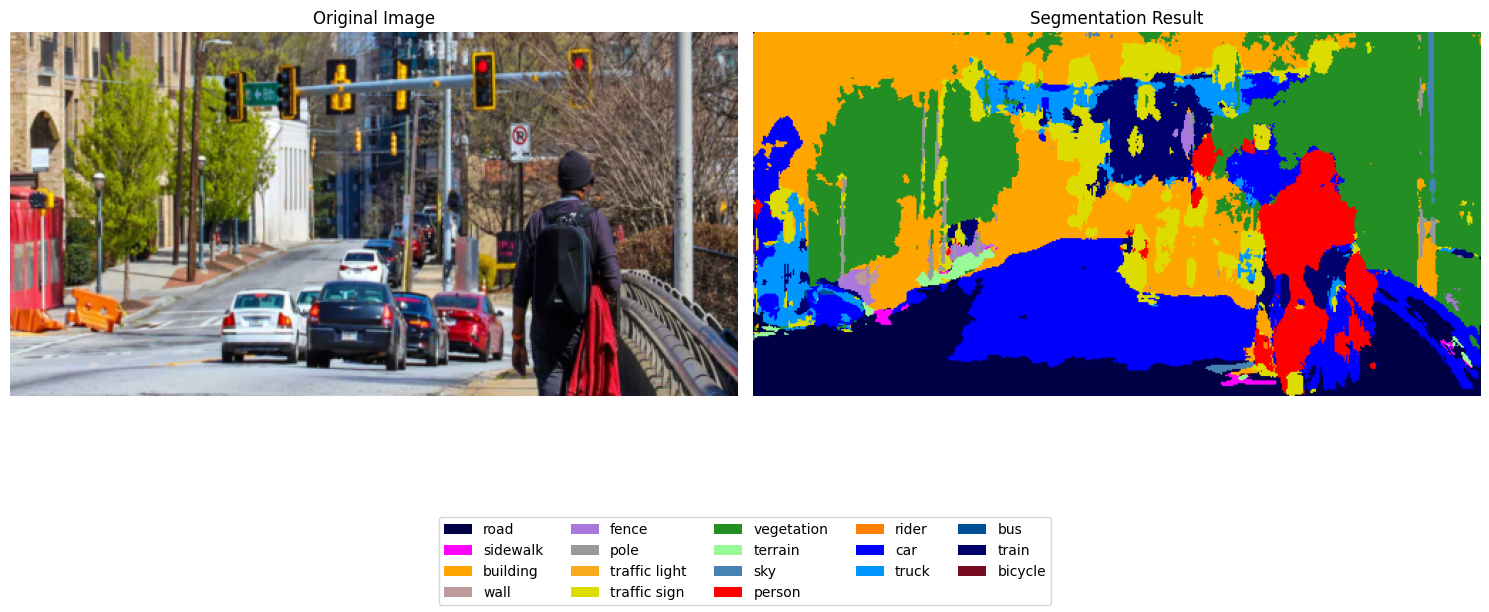

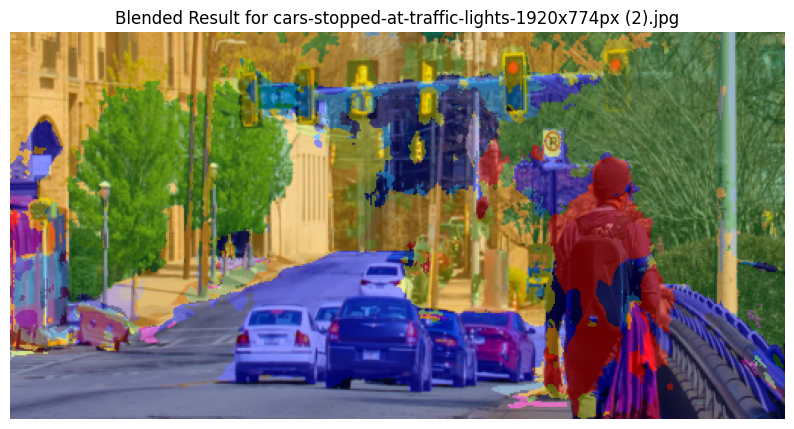


Download the output folder for all result images


In [49]:
def upload_and_segment(model):
    """Upload images through Colab and process them."""
    if model is None:
        print("No model available. Please load a model first.")
        return

    print("Please upload one or more images...")
    uploaded = files.upload()

    # Create a temporary folder for uploaded images
    temp_folder = "temp_uploads"
    os.makedirs(temp_folder, exist_ok=True)

    # Create output folder
    output_folder = "output"
    os.makedirs(output_folder, exist_ok=True)

    # Process each uploaded image
    for filename, content in uploaded.items():
        image_path = os.path.join(temp_folder, filename)

        # Save the uploaded image
        with open(image_path, 'wb') as f:
            f.write(content)

        # Run inference
        print(f"\nProcessing {filename}...")
        fig, blended, segmentation = inference(model, image_path, output_folder)

        # Display results in Colab
        plt.figure(figsize=(10, 10))
        plt.imshow(blended)
        plt.title(f"Blended Result for {filename}")
        plt.axis('off')
        plt.show()

    print("\nDownload the output folder for all result images")

# Run the upload and segment function
if model is not None:
    upload_and_segment(model)